In [1]:
%matplotlib inline

import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as snb

from scipy.optimize import minimize
from autograd import value_and_grad

from exercise11 import squared_exponential
from exercise11 import StationaryIsotropicKernel
from exercise11 import GaussianProcessRegression
from exercise11 import plot_with_uncertainty

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)


# 02477 Bayesian Machine Learning: Exercise 11

Gaussian process regression is a flexible and powerful modelling tool, but the computational complexity of $\mathcal{O}(N^3)$ can render **exact inference** for Gaussian processes infeasible for large datasets. The purpose of this week is to dive deeper into the framework of variational inference and study how to scale Gaussian processes to large datasets using **variational inference** and so-called **inducing points** to reduce the computational complexity to $\mathcal{O}(NM^2)$, where $M \ll N$ is the number of inducing points.

We will work two datasets

- the bike sharing dataset ($N = 365$), which we are already familiar with and

- a power consumption dataset ($N = 1442$),

for the purpose of investigating the accuracy of variational approximations for Gaussian processes. To do this, we will first fit a Gaussian process model with exact inference using the implementation from week 5, and then set up the variational approximation and compare the two. 

**Content**

- Part 1: Introduction and theory
- Part 2: Creating a baseline
- Part 3: Implementing the variational approximation
- Part 4: Investigating the approximation quality
- Part 5: Using the lower bound as an approximation for the log marginal likelihood
- Part 6: Predicting household power consumption



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

**Note**: If you find yourself spending more than 30minutes on a single task, consider asking for help or look up at the solution for inspiration and move forward.

---


## Part 1:  Introduction and theory

### Model specification
First, we will define our regression model. Suppose we have dataset $\mathcal{D} = \left\lbrace \mathbf{x}_n, y_n \right\rbrace_{n=1}^N$ with $\mathbf{x}_n \in \mathbb{R}^D$ and $y_n \in \mathbb{R}$ such that

$$\begin{align*}
    y_n = f(\mathbf{x}_n) + e_n,
\end{align*}$$
		
where $e_n \in \mathbb{R}$ is i.i.d. Gaussian noise and $f$ is described by a GP prior, i.e. $f(\mathbf{x}) \sim \mathcal{GP}(\mathbf{0}, k(\mathbf{x}, \mathbf{x}')$, leading to the joint distribution
$$\begin{align*}
	p(\mathbf{y}, \mathbf{f}) =  p(\mathbf{y}|\mathbf{f})p(\mathbf{f}) = \mathcal{N}(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I})\mathcal{N}(\mathbf{f}|\mathbf{0}, \mathbf{K}_{ff})\tag{1},
\end{align*}$$
where $\mathbf{K}_{ff} \in \mathbb{R}^{N \times N}$ denotes the prior covariance matrix for $\mathbf{f}$ and $\sigma > 0$ is the standard deviation of the noise. 


This is a conjugate model, so we can compute the posterior distribution $p(\mathbf{f}|\mathbf{y})$ analytically, but we know that the computation scales as $\mathcal{O}(N^3)$, and thus,  **exact posterior inference** for this model becomes infeasible for large $N$. To speed up inference and scale GPs to larger datasets, we will set up a variational approximation $q(\mathbf{f})$ such that $p(\mathbf{f}|\mathbf{y}) \approx q(\mathbf{f})$. 

### Inducing points

First, we introduce $M$ **inducing points** $\mathbf{z}_m \in \mathbb{R}^D$ for $m = 1, \dots, M$, which belong to the same space as $\mathbf{x}$. However, the inducing points are not actual, measured data points, but rather a set of virtual points we utilize to construct fast inference algorithms.

Let $u_m \in \mathbb{R}$ denote the value of the latent function evaluated at the $m$'th inducing point. That is
$$\begin{align*}
			u_m = f(\mathbf{z}_m).
\end{align*}$$

Intuitively, our goal is use the inducing points $\mathbf{z}_m \in \mathbb{R}^D$ and their function values $u_m \in \mathbb{R}$ to absorb all the information from the observed data $\mathbf{y}$.

First,  we let $\mathbf{u} = \left[u_1, u_2, \dots, u_M\right] \in \mathbb{R}^M$ denote the latent function values for the all $M$ inducing points, and then we can specify a joint distribution for data $\mathbf{y}$ and latent function values for both $\mathbf{f}$ and $\mathbf{u}$:
$$\begin{align*}
				p(\mathbf{y}, \mathbf{f}, \mathbf{u}) &= p(\mathbf{y}|\mathbf{f})p(\mathbf{f}|\mathbf{u})p(\mathbf{u})\\
				&= \mathcal{N}(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I})\mathcal{N}(\mathbf{f}|\mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{u}, \mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf})\mathcal{N}(\mathbf{u}|\mathbf{0}, \mathbf{K}_{uu}), \tag{2} 
\end{align*}$$
where $\mathbf{K}_{uu} \in \mathbb{R}^{N \times N}$ denotes the prior covariance matrix for $\mathbf{f}$ and $\mathbf{K}_{fu} \in \mathbb{R}^{N \times M}$ is the prior covariance matrix between $\mathbf{f}$ and $\mathbf{u}$. Note that the joint distribution in eq. (2) is described by a multivariate Gaussian because it represents a linear system, where all the components are Gaussian:

$$\begin{align*}
p(\mathbf{y}, \mathbf{f}, \mathbf{u})  = \mathcal{N}\left(
	\begin{bmatrix}
		\mathbf{y} \\ \mathbf{f} \\ \mathbf{u}
	\end{bmatrix} \, | \, \mathbf{0}, 
\begin{bmatrix}
	\mathbf{K}_{ff} + \sigma^2 \mathbf{I} & \mathbf{K}_{ff}  & \mathbf{K}_{fu}\\
	\mathbf{K}_{ff} & \mathbf{K}_{ff} & \mathbf{K}_{fu}\\
	\mathbf{K}_{uf} & \mathbf{K}_{uf} & \mathbf{K}_{uu}
\end{bmatrix}
\right).
\end{align*}$$

The specific construction in eq. (2) ensures that the marginal prior distribution for $\mathbf{f}$ remains $p(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{0}, \mathbf{K}_{ff})$ (as you will show in the first exercise), and hence, the posterior distribution $p(\mathbf{f}|\mathbf{y})$ will be the identical for the two models specified in eq. (1) and eq. (2). 

**Task 1.1**: Use  the sum rule to show that $p(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{0}, \mathbf{K}_{ff})$.

*Hint: This is a linear Gaussian system, so Section 3.3 in Murphy1 will be handy.*

**Solution**

We have

$$\begin{align*}
p(\mathbf{f}) = \int p(\mathbf{f}|\mathbf{u})p(\mathbf{u}) \text{d}\mathbf{u} = \int \mathcal{N}(\mathbf{f}|\mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{u}, \mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{fu})\mathcal{N}(\mathbf{u}|\mathbf{0}, \mathbf{K}_{uu})\text{d}\mathbf{u}
\end{align*}$$

Using eq. (3.38) from Section 3.3 in Murphy1 yields:

$$\begin{align*}
p(\mathbf{f}) &= \mathcal{N}(\mathbf{f}|\mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{0}, \mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf} +          \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf})\\
&= \mathcal{N}(\mathbf{f}|\mathbf{0}, \mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf} +          \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf})\\
&= \mathcal{N}(\mathbf{f}|\mathbf{0}, \mathbf{K}_{ff})
\end{align*}$$
where we have used that $\mathbf{K}_{uf}^T = \mathbf{K}_{fu}$.


**End of solution**

Again, the key take away from this constuction is that we want the inducing points it to be able to absorb all the information from the observations $\mathbf{y} \in \mathbb{R}^N$ using a smaller set of parameters $\mathbf{u} \in \mathbb{R}^M$ for $M \ll N$.

### Setting the up the variational approximation

We will set up a variational approximation for $p(\mathbf{f}, \mathbf{u}|\mathbf{y}) \approx q(\mathbf{f}, \mathbf{u})$, which subsequently allows us to compute $q(\mathbf{f}) = \int q(\mathbf{f}, \mathbf{u}) \text{d}\mathbf{u}$ such that $p(\mathbf{f}|\mathbf{y}) \approx q(\mathbf{f})$. 

Since $\mathbf{f} \in \mathbb{R}^N$ and $\mathbf{u} \in \mathbb{R}^M$ are both real-valued vectors, we could have choosen the variational family for $q(\mathbf{f}, \mathbf{u})$ to be the full-rank multivariate Gaussians. However, if we did this, then $\mathcal{Q}$ would be set the all (full-rank) Gaussians, i.e. $q(\mathbf{f}, \mathbf{u}) = \mathcal{N}\left(\begin{bmatrix} \mathbf{f}\\ \mathbf{u} \end{bmatrix}|\,\mathbf{m}, \mathbf{V}\right)$, and then the optimal approximation $q^* \in \mathcal{Q}$ would simply be equal to the exact posterior, i.e. $q^*(\mathbf{f}, \mathbf{u}) = p(\mathbf{f}, \mathbf{u}|\mathbf{y})$, and we would not have gained anything.



**Task 1.2**: How do we know that $q^*(\mathbf{f}, \mathbf{u}) = p(\mathbf{f}, \mathbf{u}|\mathbf{y})$ in this case?

*Hints:*

- *What is the joint distribution of $\mathbf{y}, \mathbf{f}, \mathbf{u}$? according to eq. (2) and how does that relate to the variational family?*

- *Answering this question does not require any calculations, but simply a couple of arguments. If you are stuck, do not hesitate to ask for help or look at the solution*.

**Solution**

The model specified in eq. (2) is a linear Gaussian system,  which implies that $p(\mathbf{y}, \mathbf{f}, \mathbf{u})$ is a joint multivariate Gaussian distribution, and hence, $p(\mathbf{f}, \mathbf{u}|\mathbf{y})$ is also a multivariate Gaussian distribution. Therefore, if we choose $\mathcal{Q}$ to be full-rank Gaussians, then $p(\mathbf{f}, \mathbf{u}|\mathbf{y}) \in \mathcal{Q}$ and hence,

$$\begin{align*}
q^*(\mathbf{f}, \mathbf{u}) = \arg\min\limits_{q \in \mathcal{Q}} \text{KL}\left[q(\mathbf{f}, \mathbf{u})||p(\mathbf{f}, \mathbf{u}|\mathbf{y})\right] = p(\mathbf{f}, \mathbf{u}|\mathbf{y}),
\end{align*}$$
since $ \text{KL}\left[p(\mathbf{f}, \mathbf{u}|\mathbf{y})||p(\mathbf{f}, \mathbf{u}|\mathbf{y})\right] = 0$.

**End of solution**

Instead, we will choose the variational family $\mathcal{Q}$ to be the set of all distributions with the following **fixed-form**:
$$\begin{align*}
			q(\mathbf{f}, \mathbf{u}) = p(\mathbf{f}|\mathbf{u})q(\mathbf{u}) = \mathcal{N}(\mathbf{f}|\mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{u}, \mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{fu}) \mathcal{N}(\mathbf{u}|\mathbf{m}_u, \mathbf{S}_u),
\end{align*}$$

where $\mathbf{m}_u \in \mathbb{R}^M$ and $\mathbf{S}_u \in \mathbb{R}^{M \times M}$ are the **variational parameters** to be estimated. This choice also implies that $q(\mathbf{f}, \mathbf{u})$ will be a multivariate Gaussian, but this time with a constrained covariance structure, which allows us to speed up inference. The resulting marginal variational approximation for $q(\mathbf{f})$ can be computed using the equations for linear Gaussian systems (see Section 3.3 in Murphy1):
$$\begin{align*}
			q(\mathbf{f}) &= \int p(\mathbf{f}|\mathbf{u})q(\mathbf{u}) \text{d} \mathbf{u}\\
			&=  \int \mathcal{N}(\mathbf{f}|\mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{u}, \mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{fu}) \mathcal{N}(\mathbf{u}|\mathbf{m}_u, \mathbf{S}_u)\text{d} \mathbf{u}\\
			&=  \mathcal{N}(\mathbf{f}|\underbrace{\mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{m}_u}_{\mathbf{m}_f}, \underbrace{\mathbf{K}_{ff} +\mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}(\mathbf{S}_u - \mathbf{K}_{uu})\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf}}_{\mathbf{S}_f}).
\end{align*}$$

For example, the expression for $\mathbf{m}_f = \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{m}_u \in \mathbb{R}^N$ shows that posterior mean of the latent functions values for $\mathbf{f} \in \mathbb{R}^N$ is now completely specified by **lower-dimensional** quantity $\mathbf{m}_u \in \mathbb{R}^M$ assuming $M \ll N$.  

### Computing the optimal variational appproximation $q^*$

To compute the optimal values of the variational parameters, $\mathbf{m}_u \in \mathbb{R}^M$ and  $\mathbf{S}_u \in \mathbb{R}^{M \times M}$, we compute the evidence lower bound $\mathcal{L}\left[q\right]$ as derived in the videos and optimize it with respect to $\mathbf{m}_u, \mathbf{S}_u$:

$$\begin{align*}
\mathbf{m}_u^*, \mathbf{S}_u^* = \arg\max\limits_{\mathbf{m}_u, \mathbf{S}_u} \mathcal{L}[q] &= \arg\max\limits_{\mathbf{m}_u, \mathbf{S}_u} \left[\log \mathcal{N}(\mathbf{y}|\mathbf{m}_{f}, \sigma^2\mathbf{I})  - \frac{1}{2\sigma} \text{trace}(\mathbf{S}_f) - \text{KL}\left[{q(\mathbf{u})} || {p(\mathbf{u})} \right] \right] \tag{3}
\end{align*}$$

which can be solved analytically:
$$\begin{align*}
	\mathbf{S}_u^{-1} &=  \frac{1}{\sigma^2} \mathbf{K}_{uu}^{-1} \mathbf{K}_{uf} \mathbf{K}_{fu} \mathbf{K}_{uu}^{-1} + \mathbf{K}_{uu}^{-1}\tag{4}\\
	\mathbf{m}_u &= \frac{1}{\sigma^2}\mathbf{S}_u\mathbf{K}_{uu}^{-1} \mathbf{K}_{uf}\mathbf{y}\tag{5}.
\end{align*}$$

and then we can make predictions for $f^* = f(\mathbf{x}^*)$ for any new input point $\mathbf{x}^* \in \mathbb{R}^D$:
\begin{align*}
	p(f^*|\mathbf{y}) &= \int p(f^*|\mathbf{u})p(\mathbf{u}|\mathbf{y}) \text{d}\mathbf{u}\\
	%
	&\approx \int p(f^*|\mathbf{u})q(\mathbf{u}) \text{d}\mathbf{u}\\
	%
	&= \mathcal{N}(f^*|\underbrace{\mathbf{K}_{f^*u}\mathbf{K}_{uu}^{-1}\mathbf{m}_u}_{\mathbf{m}_{f^*}}, \underbrace{\mathbf{K}_{f^*f^*} +\mathbf{K}_{f^*u}\mathbf{K}_{uu}^{-1}(\mathbf{S}_u - \mathbf{K}_{uu})\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf^*}}_{\mathbf{S}_{f^*}}), 
\end{align*}

where $\mathbf{K}_{f^*u}$ is the prior covariance between $f^*$ and $\mathbf{u}$ and $\mathbf{K}_{f^*f^*}$ is the prior covariance for $f^*$. 


### Hyperparameter estimation

Next, we address how to estimate the hyperparameters of the model, e.g. kernel hyperparameters and the standard deviation of the noise $\sigma$? Let $\theta$ denote the hyperparameters of the model. Since the ELBO is a lower bound on $\log p(\mathbf{y}|\theta)$,
$$\begin{align*}
\log p(\mathbf{y}|\theta) &= \mathcal{L}_{\theta}\left[q\right] + \text{KL}\left[q(\mathbf{f}, \mathbf{u})||p(\mathbf{f}, \mathbf{u}|\mathbf{y}, \theta)\right] > \mathcal{L}_{\theta}\left[q(\mathbf{f}, \mathbf{u})\right],
\end{align*}$$
 we can simply maximize the ELBO wrt. $\theta$ as a proxy. To make this more efficient, we can substitute the solution for $\mathbf{m}_u^*, \mathbf{S}_u^*$ into eq. (3) to obtain the **collapsed lowerbound**:
$$\begin{align*}
			\mathcal{L}_{\theta}\left[q\right] &= \log \mathcal{N}(\mathbf{y}|  \mathbf{0}, \mathbf{K}_{fu} \mathbf{K}_{uu}^{-1} \mathbf{K}_{uf} + \sigma^2\mathbf{I})  - \frac{1}{2\sigma} \text{trace}(\mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1} \mathbf{K}_{uf}). \tag{6}
\end{align*}$$

and then estimate the hyperparameters as follows
$$\begin{align*}
\theta^* = \arg\max\limits_{\theta} \log p(\mathbf{y}|\theta) \approx \arg\max\limits_{\theta} \mathcal{L}_{\theta}\left[q\right].
\end{align*}$$

In this exercise, we will use a squared exponential kernel, and therefore, the set of hyperparameters will be $\theta = \left\lbrace \kappa, \ell, \sigma\right\rbrace$, where $\kappa > 0$ is the magnitude parameter of the kernel, $\ell > 0$ is the lengthscale and $\sigma > 0$ is the standard deviation of the noise.

### Choosing the number and position of the inducing points

Now we will turn our attention to the number $M$ and position of the inducing points $\left\lbrace \mathbf{z}_m \right\rbrace_{m=1}^M$, which is the last piece of the puzzle. Despite the joint distribution in eq. (2), the resulting posterior of $\mathbf{f}$, i.e. $p(\mathbf{f}|\mathbf{y})$, is actually **independent** of the inducing points, and hence, we can think of the **inducing points as variational parameters**. This means that  we can simply initialize $\left\lbrace \mathbf{z}_m \right\rbrace_{m=1}^M$ randomly and then optimize the lowerbound wrt. $\left\lbrace \mathbf{z}_m \right\rbrace_{m=1}^M$ to learn optimal positions of the inducing points. It is common practice to initialize $\left\lbrace \mathbf{z}_m \right\rbrace_{m=1}^M$ using a random subset of the data and then optimize the positions via the lowerbound. Because these methods make predictions via a small set of points, these methods are often refered to as **sparse Gaussian processes**.

One can show that as $M$ increases, the quality of the approximation $p(\mathbf{f}|\mathbf{y}) \approx q(\mathbf{y})$ increases, and hence, $M$ allows us to trade off speed with accuracy. Moreover, in most practical applications, it is possible to choose $M$ to get a significant speed without loosing any accuracy.

To keep things simple in this exercise, we will choose $\left\lbrace \mathbf{z}_m \right\rbrace_{m=1}^M$ to be on a fixed grid in the input space and then study the effect of varying $M$.



**Task 1.3**: Argue/show that the collapsed lowerbound becomes the exact log marginal likelihood if you choose the set of inducing points to be the set of inputs points, i.e. $\mathbf{z}_n = \mathbf{x}_n$ for $n = 1, \dots, N$.

*Hints: Start with the expression for the collapsed lower bound and consider what happens to the kernel matrices when $\mathbf{z}_n = \mathbf{x}_n$ for $n = 1, \dots, N$?*

**Solution**

Assume we choose the inducing points to be equal to the input points, i.e. $\mathbf{z}_n = \mathbf{x}_n$ for all $n$, then $\mathbf{K}_{fu} = \mathbf{K}_{uf} = \mathbf{K}_{uu} =  \mathbf{K}_{ff}$. Substituing this into eq. (6) above yields

$$\begin{align*}
\mathcal{L}_{\theta}\left[q\right] &= \log \mathcal{N}(\mathbf{y}|  \mathbf{0}, \mathbf{K}_{fu} \mathbf{K}_{uu}^{-1} \mathbf{K}_{uf} + \sigma^2\mathbf{I})  - \frac{1}{2\sigma} \text{trace}(\mathbf{K}_{ff} - \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1} \mathbf{K}_{uf})\\
%
&=\log \mathcal{N}(\mathbf{y}|  \mathbf{0}, \mathbf{K}_{ff} \mathbf{K}_{ff}^{-1} \mathbf{K}_{ff} + \sigma^2\mathbf{I})  - \frac{1}{2\sigma} \text{trace}(\mathbf{K}_{ff} - \mathbf{K}_{ff}\mathbf{K}_{ff}^{-1} \mathbf{K}_{ff})\\
%
&= \log \mathcal{N}(\mathbf{y}|  \mathbf{0},  \mathbf{K}_{ff} + \sigma^2\mathbf{I})  - \frac{1}{2\sigma} \text{trace}(\mathbf{K}_{ff} - \mathbf{K}_{ff})\\
%
&= \log \mathcal{N}(\mathbf{y}|  \mathbf{0},  \mathbf{K}_{ff} + \sigma^2\mathbf{I})\\
%
&= \log p(\mathbf{y}|\theta)
\end{align*}$$

**End of solution**




---


## Part 2:  Creating a baseline

Initially, we will study the variational approximation and its properties using the **bike sharing data set**, which we worked with earlier. First, we will load the data and split it into a training and a set test:

N_train = 292
N_test = 73


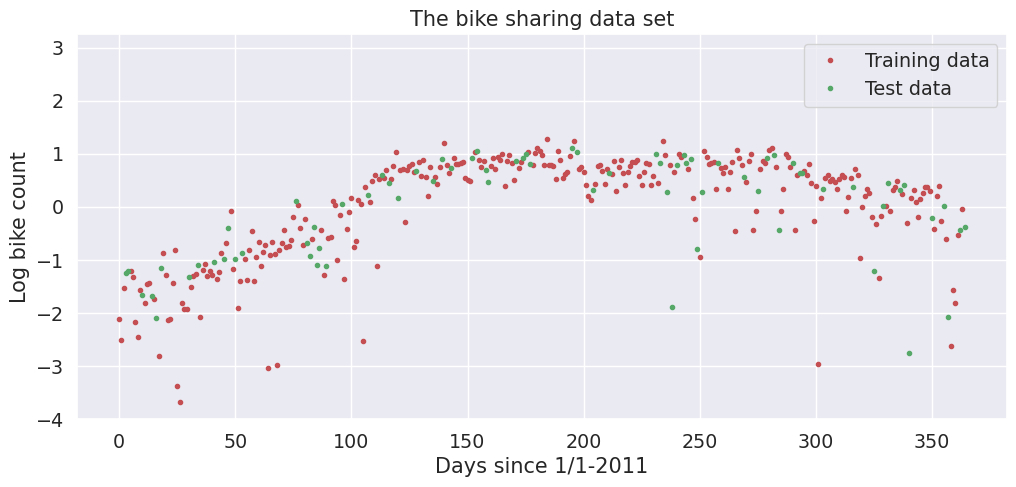

In [5]:
# load bake sharing dataset
data = np.load('./../exercise5/data_exercise5b.npz')
X_full = data['day']
y_full = np.log(data['bike_count'])

# generate training/test split
np.random.seed(1234)
N_full = len(X_full)
idx_train = np.random.choice(range(N_full), size=int(0.8*N_full), replace=False)
idx_test = np.setdiff1d(range(N_full), idx_train)

# split data
X_train, X_test = X_full[idx_train], X_full[idx_test]
y_train, y_test = y_full[idx_train], y_full[idx_test]

# remove mean and scale to unit variance
ym, ys = np.mean(y_train), np.std(y_train)
y_train = (y_train-ym)/ys
y_test = (y_test-ym)/ys

# plot result
def plot_data(ax):
    ax.plot(X_train, y_train, 'r.', label='Training data')
    ax.plot(X_test, y_test, 'g.', label='Test data')
    ax.legend()
    ax.set(xlabel='Days since 1/1-2011', ylabel='Log bike count', ylim=(-4, 3.25));

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_data(ax)
ax.set_title('The bike sharing data set')

print(f'N_train = {len(X_train)}')
print(f'N_test = {len(X_test)}')

Before implementing the variational approximation, we will first set up a baseline using exact Gaussian process regression from week 5. We will choose a squared exponential kernel and use the marginal likelihood for hyperparameter optimization.

In [6]:
# full GP
gp_exact = GaussianProcessRegression(X_train, y_train, StationaryIsotropicKernel(squared_exponential))
gp_exact.optimize_hyperparameters(theta_init=np.array([1, 1, 1.]))

print('Estimated hyperparameters')
print(f'\tkappa: {gp_exact.kappa:3.2f}')
print(f'\tscale: {gp_exact.lengthscale:3.2f}')
print(f'\tsigma: {gp_exact.sigma:3.2f}')
print('')
print(f'Log marginal likelihood: {gp_exact.log_marginal_likelihood(gp_exact.kappa, gp_exact.lengthscale, gp_exact.sigma):3.2f}')


Estimated hyperparameters
	kappa: 1.14
	scale: 85.52
	sigma: 0.55

Log marginal likelihood: -250.59


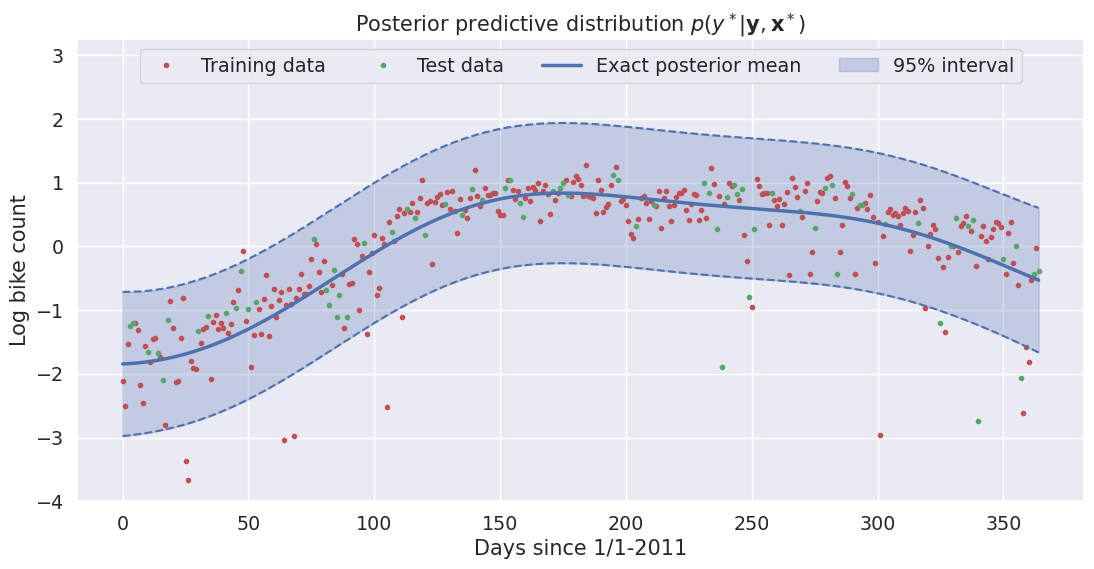

In [7]:
# interval for predictions
Xstar = np.arange(0, 365)[:, None]

# visualize
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
plot_data(ax)
plot_with_uncertainty(ax, Xstar, gp_exact, label='Exact posterior mean', title='Posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$', num_samples=0, color='b')
ax.legend(loc='upper center', ncol=4);


--- 


## Part 3:  Implementing the variational approximation

The goal of this task is to implement the variational approximation of the Gaussian process regression model.
The class `VariationalGaussianProcessRegression` below contains an incomplete implementation and your task is to complete the implementation by implementing the functions `compute_posterior_u`, `predict_f`, and `lowerbound`. 

**Task 3.1**: Complete the implementation of the function `compute_posterior_u`, which must compute and return the posterior mean and covariance for $\mathbf{u}$, i.e. $\mathbf{m}_u$ and $\mathbf{S}_u$. The expressions are stated below for convenience:

$$\begin{align*}
	\mathbf{S}_u^{-1} &=  \frac{1}{\sigma^2} \mathbf{K}_{uu}^{-1} \mathbf{K}_{uf} \mathbf{K}_{fu} \mathbf{K}_{uu}^{-1} + \mathbf{K}_{uu}^{-1}\\
	\mathbf{m}_u &= \frac{1}{\sigma^2}\mathbf{S}_u\mathbf{K}_{uu}^{-1} \mathbf{K}_{uf}\mathbf{y}.
\end{align*}$$


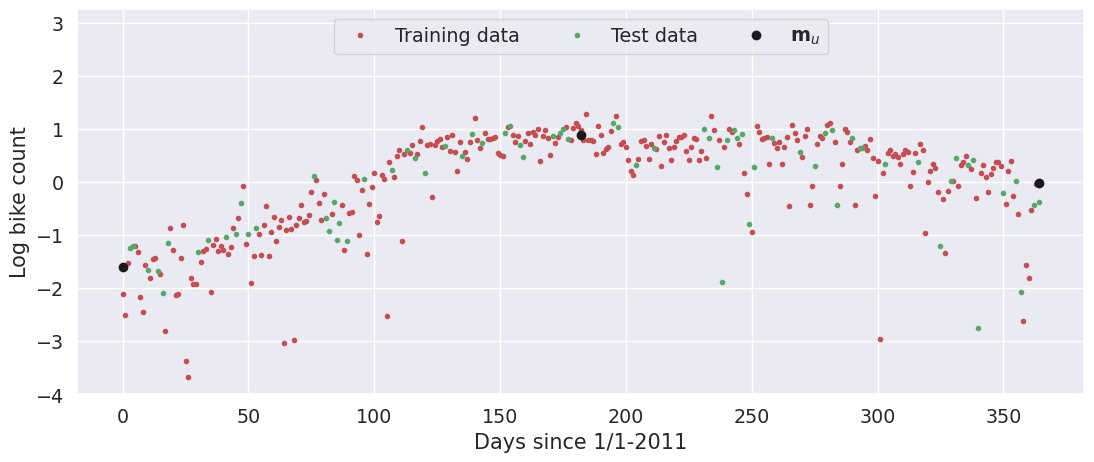

In [9]:
def log_mvn_pdf(x, m, V):
    """ evaluates the log density of a multivariate Gaussian distribution with mean m and covariance V at x """
    L = np.linalg.cholesky(V)
    b = x.ravel() - m.ravel()
    v = np.linalg.solve(L, b)
    return -0.5*v.T@v - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.sum(np.log(np.diag(L**2)))

class VariationalGaussianProcessRegression(object):

    def __init__(self, X, y, Z, kernel, kappa=1, lengthscale=1, sigma=1.):

        # store data etc
        self.X = X
        self.Z = Z
        self.y = y
        self.N = len(X)
        self.M = len(Z)
        self.kernel = kernel
        self.set_hyperparameters(kappa, lengthscale, sigma)

    def set_hyperparameters(self, kappa, lengthscale, sigma):
        self.kernel.kappa, self.kernel.lengthscale, self.sigma = kappa, lengthscale, sigma 

    def compute_posterior_u(self):
        """ compute and returns the posterior mean and covariance of u, i.e m_u and S_u """

        ##############################################
        # Your solution goes here
        ##############################################
        
        self.Kzz = self.kernel.contruct_kernel(self.Z, self.Z)
        self.Kzx = self.kernel.contruct_kernel(self.Z, self.X)
        self.W = np.linalg.solve(self.Kzz, self.Kzx)
        self.Lambda = 1./self.sigma**2*(self.W@self.W.T) + np.linalg.inv(self.Kzz)
        m_u = 1./self.sigma**2*np.linalg.solve(self.Lambda, self.W@self.y)
        S_u = np.linalg.inv(self.Lambda)
        
        ##############################################
        # End of solution
        ##############################################

        # check dimensions and return
        assert m_u.shape == (self.M, 1), f'The dimension of m_u is wrong. Expected ({self.M}, 1), but the actual shape was {m_u.shape}'
        assert S_u.shape == (self.M, self.M), f'The dimension of S_u is wrong. Expected ({self.M}, {self.M}), but the actual shape was {S_u.shape}'
        return m_u, S_u
    

    def predict_f(self, Xstar):
        """ returns the posterior distribution of y^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        m_f               -- Px1 mean vector
        S_f               -- PxP covariance matrix
        """
        ##############################################
        # Your solution goes here
        ##############################################
        
        mu, Su = self.compute_posterior_u()
        Kzxstar = self.kernel.contruct_kernel(self.Z, Xstar)
        Kxstar = self.kernel.contruct_kernel(Xstar, Xstar)
        h = np.linalg.solve(self.Kzz, Kzxstar)
        m_f = h.T@mu
        S_f = Kxstar - h.T @ (self.Kzz - Su) @ h
        
        ##############################################
        # End of solution
        ##############################################

        # check dimensions and return
        assert m_f.shape == (len(Xstar), 1), f'The dimension of m_f is wrong. Expected ({len(Xstar)}, 1), but the actual shape was {m_f.shape}'
        assert S_f.shape == (len(Xstar), len(Xstar)), f'The dimension of S_f is wrong. Expected ({len(Xstar)}, {len(Xstar)}), but the actual shape was {S_f.shape}'
        return m_f, S_f
    

    def predict_y(self, Xstar):
        """ returns the posterior distribution of y^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        mu               -- Px1 mean vector
        Sigma            -- PxP covariance matrix
        """
        mu_f, var_f = self.predict_f(Xstar)
        return mu_f, var_f + self.sigma**2*np.identity(len(Xstar))
    

    def lowerbound(self):
        """ evaluates the collapsed lowerbound from eq. (6) """
        ##############################################
        # Your solution goes here
        ##############################################
        
        # prepare
        mu, Su = self.compute_posterior_u()
        Q = self.Kzx.T @ self.W
        K = Q + self.sigma**2*np.identity(len(self.y))
        # we only need the diagonal of Kxx
        Kff_diag = self.kernel.kappa**2 * np.ones((self.N))
        # compute bound
        L = log_mvn_pdf(self.y.ravel(), np.zeros(self.N), K) - 0.5*(1/self.sigma**2)*(Kff_diag - np.diag(Q)).sum()
        
        ##############################################
        # End of solution
        ##############################################

        return L

    def optimize_hyperparameters(self, theta_init):

        # define optimization objective as the negative log marginal likelihood
        def objective(params):
            self.set_hyperparameters(*np.exp(params))
            return -self.lowerbound()

        # optimize using gradients
        res = minimize(value_and_grad(objective), np.log(theta_init), jac=True)

        # save and return results
        theta = np.exp(res.x)
        self.set_hyperparameters(*theta)
        return theta

# specify number and position of the inducing points
M =3
Z = np.linspace(0, 364, M)[:, None]

# set-up variational GP and compute posterior mean of u
kernel = StationaryIsotropicKernel(squared_exponential, 1, 100)
vgp = VariationalGaussianProcessRegression(X_train, y_train, Z, kernel)
m_u, S_u = vgp.compute_posterior_u()

# visualize data
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
plot_data(ax)

# plot position and posterior mean of inducing points
ax.plot(Z, m_u, 'ko', label='$\mathbf{m}_u$')
ax.legend(loc='upper center', ncol=5);


If the task above is solved correctly, the cell above should plot the posterior mean for each inducing points (black dots) on top of the data points.

**Task 3.2**: Play around with the number of inducing points. How many inducing points do you think it takes to represent this data well? (we will investigate this later) [**Discussion question**]



**Task 3.3**: Complete the implementation of the functions `predict_f` for computing $p(f^*|\mathbf{y})$ and (collapsed) `lowerbound` for evaluating the collaped lowerbound in the class `VariationalGaussianProcessRegression` above.

*Hints*: 
- *The equations for predicting $f^*$ is very similar to the equations you implemented for the Laplace approximation.*
- *When implementing the `lowerbound`-function, consider using the `log_mvn_pdf` for evaluating the multivariate normal. You could also use `scipy.stats.multivariate_normal`, but this implementation can be rather slow.*
- *To test your implementation of `predict_f` before implementing the `lowerbound`-function, comment out the line `vgp.optimize_hyperparameters([1,15,1]` and run the cell below. But remember to uncomment the line again*

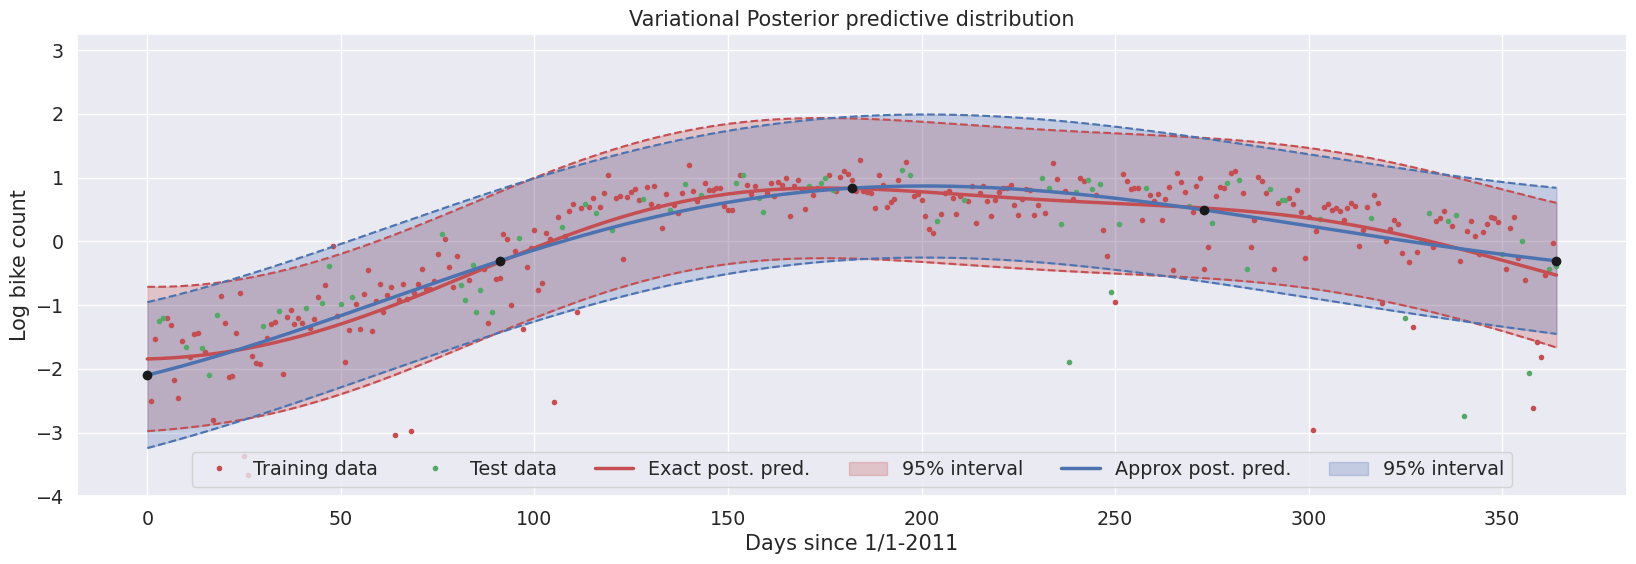

In [14]:
# variational Gaussian process
M = 5
Z = np.linspace(0, 364, M)[:, None]
kernel = StationaryIsotropicKernel(squared_exponential, 1, 100)
vgp = VariationalGaussianProcessRegression(X_train, y_train, Z, kernel, kappa=1, lengthscale=100, sigma=0.3)
vgp.optimize_hyperparameters([1,15,1])
m_u, S_u = vgp.compute_posterior_u()

# days for predictions
Xstar = np.arange(0, 365)[:, None]

# visualize
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
plot_data(ax)
plot_with_uncertainty(ax, Xstar, gp_exact, title='Posterior predictive distribution', num_samples=0, color='r', label='Exact post. pred.')
plot_with_uncertainty(ax, Xstar, vgp, title='Variational Posterior predictive distribution', num_samples=0, color='b', label='Approx post. pred.')
ax.plot(Z, m_u, 'ko')
ax.legend(loc='lower center', ncol=6);

If your code is implemented correctly, the plot above should show both the exact posterior predictive distribution and the approximate posterior predictive distribution.

**Task 3.4**: Play around with the number of inducing points. Investigate how the approximation behaves as your change $M$. What happens when $M$ becomes really small, say $M = 2$ or $M=3$? [**Discussion question**]

---




## Part 4:  Investigating the approximation quality

Next, we will compare the performance of the variational approximation to exact inference more quantitatively. To quantify the predictive performance, we will use mean log predictive density (LPD) for the test set $\mathcal{D}_{\text{test}} = \left\lbrace \mathbf{x}_i^*, y^*_i \right\rbrace_{i=1}^P$. For this model, the LPD is given by

$$\begin{align*}
\text{LPD} = \frac{1}{P}\sum_{i=1}^P \log p(y^*_i|\mathbf{y}, \mathbf{x}^*_i) =  \frac{1}{P}\sum_{i=1}^P \log \mathcal{N}(y^*_i|m^*_i, v^*_i),
\end{align*}$$

where $m_i^*$ and $v_i^*$ is the mean and variance of the posterior predictive distribution for $y^*_i$, respectively. We will also compute the same quantify for the training set.


In [15]:
# implement a function for evaluating the log predictive density
log_npdf = lambda x, m, v: -0.5*np.log(2*np.pi*v) -0.5*(x-m)**2/v
def compute_LPD(y, mu, var):
    return log_npdf(y.ravel(), mu.ravel(), var.ravel()).mean()

# evaluate for both training and test set
y_train_mu, y_train_var = gp_exact.predict_y(X_train)
y_test_mu, y_test_var = gp_exact.predict_y(X_test)

print(30*'*')
print('LPDs for exact GP inference')
print(30*'*')
print(f'Training LPD: {compute_LPD(y_train, y_train_mu, np.diag(y_train_var)):3.2f}')
print(f'    Test LPD: {compute_LPD(y_test, y_test_mu, np.diag(y_test_var)):3.2f}')


******************************
LPDs for exact GP inference
******************************
Training LPD: -0.80
    Test LPD: -0.97


**Task 4.1**: Fit the variational approximation for $M \in \left\lbrace 2, 3, \dots,  20\right\rbrace$ and estimate the training and test LPD for each $M$. Plot the predictive performance for the training and test set and compare to results for exact inference. How many inducing points do you need to before the difference in predictive performance between exact and approximate inference becomes negligible?

**Solution**

First, we implement a for loop for fitting the varitiational approximation for different values of $M$.

In [16]:
# compute traing and test LPD using exact inference
y_train_mu, y_train_var = gp_exact.predict_y(X_train)
y_test_mu, y_test_var = gp_exact.predict_y(X_test)

# compute exact log marginal likelihood
log_marginal_lik = gp_exact.log_marginal_likelihood(gp_exact.kappa, gp_exact.lengthscale, gp_exact.sigma)

# preallocate
train_lpds = []
test_lpds = []
lowerbounds = []

# loop over different values for M
Ms = np.arange(1, 20+1)
for M in Ms:

    # choose inducing points and fit GP
    Z = np.linspace(0, 364, M)[:, None]
    kernel = StationaryIsotropicKernel(squared_exponential, 1, 100)
    vgp = VariationalGaussianProcessRegression(X_train, y_train, Z, kernel, kappa=1, lengthscale=50, sigma=0.1)
    vgp.optimize_hyperparameters(np.array([1, 50, 1]))

    # make predictions
    y_train_mu_vgp, y_train_var_vgp = vgp.predict_y(X_train)
    y_test_mu_vgp, y_test_var_vgp = vgp.predict_y(X_test)

    # store results
    train_lpds.append(compute_LPD(y_train, y_train_mu_vgp, np.diag(y_train_var_vgp)))
    test_lpds.append(compute_LPD(y_test, y_test_mu_vgp, np.diag(y_test_var_vgp)))
    lowerbounds.append(vgp.lowerbound())

... and then we plot the results:

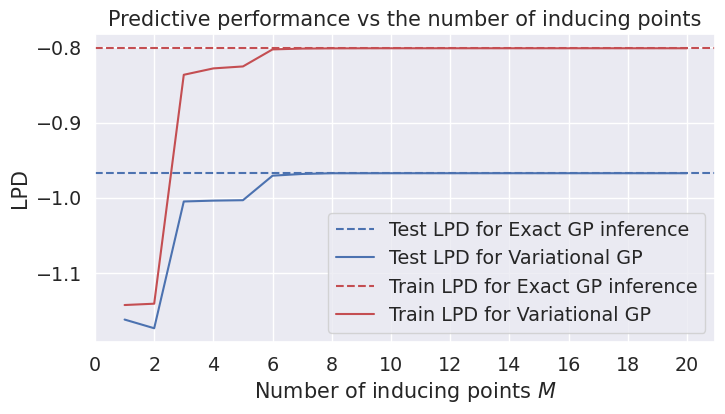

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.axhline(compute_LPD(y_test, y_test_mu, np.diag(y_test_var) ), color='b', linestyle='--', label='Test LPD for Exact GP inference')
ax.plot(Ms, test_lpds, color='b', label='Test LPD for Variational GP')
ax.axhline(compute_LPD(y_train, y_train_mu, np.diag(y_train_var) ), color='r', linestyle='--', label='Train LPD for Exact GP inference')
ax.plot(Ms, train_lpds, color='r', label='Train LPD for Variational GP')
ax.legend()
ax.set(xlabel='Number of inducing points $M$', ylabel='LPD', title='Predictive performance vs the number of inducing points', xticks=np.arange(0, 21, 2));

**End of solution**

**Task 4.2**: Make a similar plot for the value of the evidence lowerbound as a function of the number of inducing points $M$. What can we say about the KL-divergence between the approximation and the exact posterior distribution if the ELBO is approaching the log marginal likelihood?

**Solution**

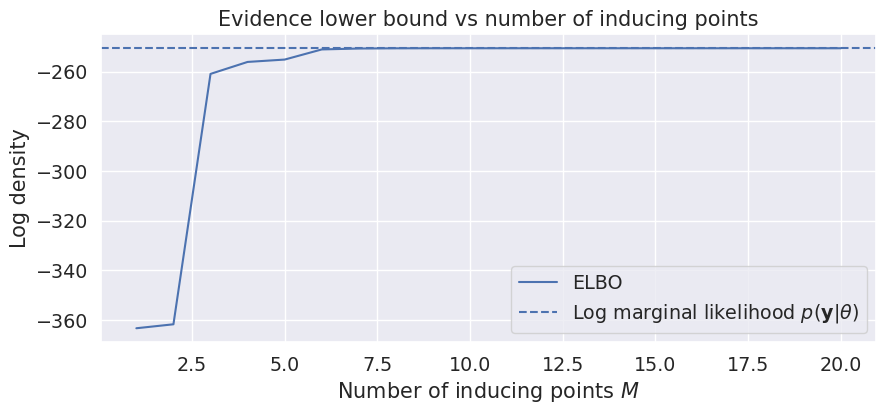

In [340]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(Ms, lowerbounds, 'b', label='ELBO')
ax.axhline(log_marginal_lik, linestyle='--', label='Log marginal likelihood $p(\mathbf{y}|\\theta)$')
ax.legend()
ax.set(xlabel='Number of inducing points $M$', ylabel='Log density', title='Evidence lower bound vs number of inducing points');


Since
$$\begin{align*}
\log p(\mathbf{y}|\theta) &= \mathcal{L}_{\theta}\left[q\right] + \text{KL}\left[q(\mathbf{f}, \mathbf{u})||p(\mathbf{f}, \mathbf{u}|\mathbf{y}, \theta)\right] > \mathcal{L}_{\theta}\left[q(\mathbf{f}, \mathbf{u})\right],
\end{align*}$$
we can conclude that $\text{KL}\left[q(\mathbf{f}, \mathbf{u})||p(\mathbf{f}, \mathbf{u}|\mathbf{y})\right] \rightarrow 0$ as $\mathcal{L}_{\theta}\left[q\right] \rightarrow \log p(\mathbf{y}|\theta)$

**End of solution**

**Task 4.3**: Using inducing points on a fixed grid works really well for 1D problems, but less so in higher dimensions. Why? [**Discussion questions**]

---

## Part 5:  Using the lower bound as an approximation for the log marginal likelihood

We argued above that we can use the lowerbound as an approximation of the log marginal likelihood $\log p(\mathbf{y}|\theta)$ for the purpose of model selection, hyperparameter tuning etc.  In this part, we will investigate the relationship between the lowerbound and the log marginal likelihood more in depth. 

As before, we will first compute the exact log marginal likelihood $\log p(\mathbf{y}|\theta)$ as function of $\theta = \left\lbrace \kappa, \ell, \sigma \right\rbrace$. However, for visualization purposes, we will fix $\kappa = 1$ and plot $\log p(\mathbf{y}|\theta)$ as a function of $\ell$ and $\sigma$.

In [19]:
class Grid2D(object):
    """ helper class for evaluating the function func on the grid defined by (ell, sigma)"""

    def __init__(self, lengthscale, sigma, func, name="Grid2D"):
        self.lengthscale = lengthscale
        self.sigma = sigma
        self.grid_size = (len(self.lengthscale), len(self.sigma))
        self.mu_grid, self.tau_grid = np.meshgrid(lengthscale, sigma, indexing='ij')
        self.func = func
        self.name = name
        
        # evaluate function on each grid point
        self.values = np.zeros((len(self.lengthscale), len(self.sigma)))
        for idx_ell, ell in enumerate(self.lengthscale):
            for idx_sigma, sigma in enumerate(self.sigma):
                self.values[idx_ell, idx_sigma] = self.func(ell, sigma)

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        maxval = np.max(f(self.values))
        levels = np.linspace(maxval-200, maxval, num_contours)
        ax.contour(self.lengthscale, self.sigma, f(self.values).T, levels=levels)
        ax.plot([-1000], [-1000], color=color, label=self.name) # hack to get a legend for the contour plot
        ax.set(xlabel='$\\ell$', ylabel='$\\sigma$', xlim=(self.lengthscale[0], self.lengthscale[-1]), ylim=(self.sigma[0], self.sigma[-1]))

    @property
    def argmax(self):
        idx = np.argmax(self.values)
        scale_idx, sigma_idx = np.unravel_index(idx, self.grid_size)
        return self.lengthscale[scale_idx], self.sigma[sigma_idx]
    
# define grid for hyperparameters
sigma_grid = np.logspace(-1, 1, 50)
scale_grid = np.logspace(-1, 5, 51)
kappa = 1

def exact_log_marginal_likelihood(scale, sigma):
    gp = GaussianProcessRegression(X_train, y_train, StationaryIsotropicKernel(squared_exponential))
    return gp.log_marginal_likelihood(kappa, scale, sigma)

exact_log_marginal_likelihood_grid = Grid2D(scale_grid, sigma_grid, exact_log_marginal_likelihood, name='$\log p(\mathbf{y}|\\theta)$')

Since the log marginal likelihood is not easy to vectorize, the 'Grid2D´-class has been modified to use a for-loop when evaluating the values for the grid and, consequently, the code becomes a bit slower.

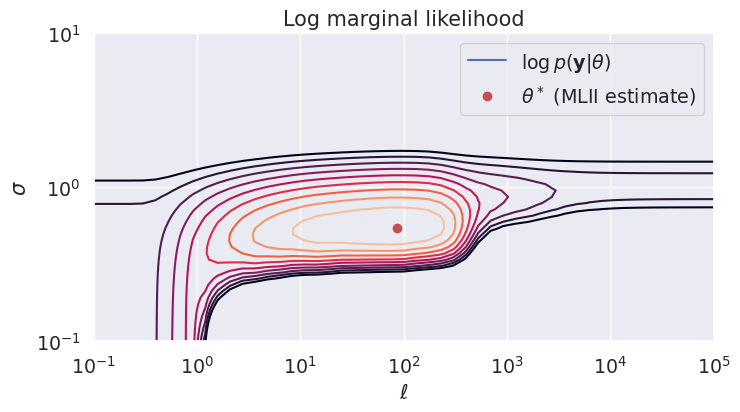

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
exact_log_marginal_likelihood_grid.plot_contours(ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(gp_exact.lengthscale, gp_exact.sigma, 'ro', label='$\\theta^*$ (MLII estimate)')
ax.set_title('Log marginal likelihood')
ax.legend();

**Task 5.1**: Create similar plots for the evidence lowerbound for $M = \left\lbrace 10, 30, 50, 100 \right\rbrace$. How well does the lowerbound approximate the log marginal likelihood?


**Solution**

In [21]:
# specify values of M
Ms = [10, 30, 50, 100]

# for each value of M
evidence_lowerbound = {}
for M in Ms:

    print(f'Running with M = {M}')

    # create inducing points
    Z = np.linspace(0, 364, M)[:, None]

    def evidence_lowerbound_function(scale, sigma):
        vgp = VariationalGaussianProcessRegression(X_train, y_train, Z, StationaryIsotropicKernel(squared_exponential), kappa=kappa, lengthscale=scale, sigma=sigma)
        return vgp.lowerbound()

    evidence_lowerbound[M] = Grid2D(scale_grid, sigma_grid, evidence_lowerbound_function, name=f'ELBO (M = {M})')

Running with M = 10
Running with M = 30
Running with M = 50
Running with M = 100


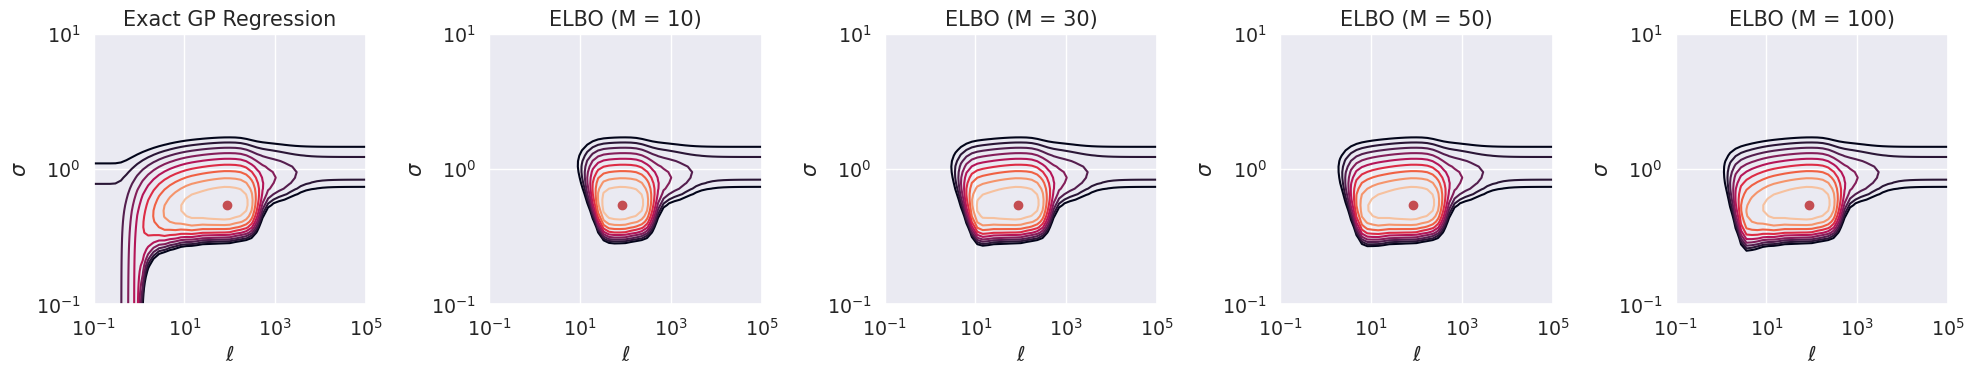

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
exact_log_marginal_likelihood_grid.plot_contours(ax[0])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot(gp_exact.lengthscale, gp_exact.sigma, 'ro')
ax[0].set_title('Exact GP Regression')

for idx, M in enumerate(Ms):
    evidence_lowerbound[M].plot_contours(ax[1+idx])
    ax[1+idx].set_xscale('log')
    ax[1+idx].set_yscale('log')
    ax[1+idx].plot(gp_exact.lengthscale, gp_exact.sigma, 'ro')
    ax[1+idx].set_title(f'ELBO (M = {M})')
fig.tight_layout()

**End of solution**


---


## Part 6:  Predicting household power consumption

The goal of the last part is to evaluate the variational approximation for a more challenging dataset, where the goal is to predict household power consumption.

N_train = 1153
N_test = 289


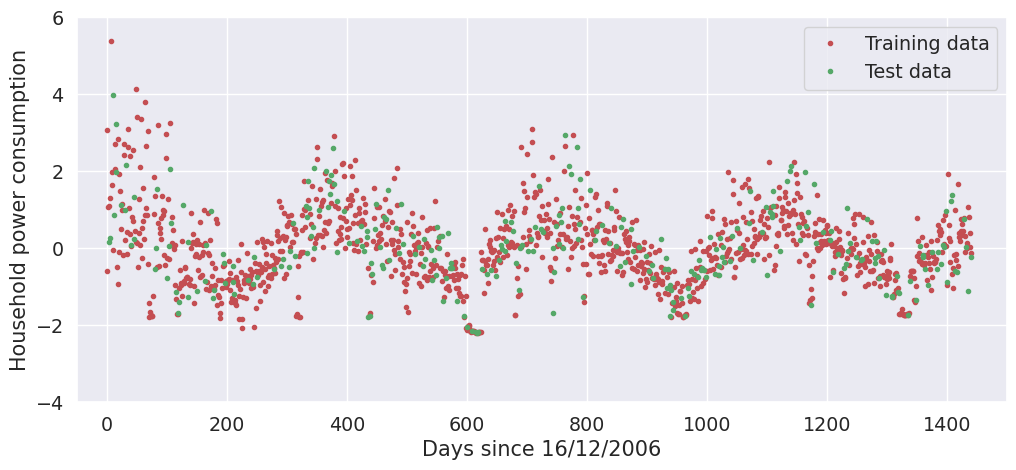

In [23]:
# load data
data = np.load('./power_data.npz', allow_pickle=True)
dates_full = data['dates']
X_full = data['X']
y_full = data['y']

# generate training/test split
np.random.seed(1234)
N_full = len(X_full)
idx_train = np.random.choice(range(N_full), size=int(0.8*N_full), replace=False)
idx_test = np.setdiff1d(range(N_full), idx_train)

# split data
X_train, X_test = X_full[idx_train, None], X_full[idx_test, None]
y_train, y_test = y_full[idx_train, None], y_full[idx_test, None]

# remove mean and scale to unit variance
ym, ys = np.mean(y_train), np.std(y_train)
y_train = (y_train-ym)/ys
y_test = (y_test-ym)/ys

# plot result
def plot_data(ax):
    ax.plot(X_train, y_train, 'r.', label='Training data')
    ax.plot(X_test, y_test, 'g.', label='Test data')
    ax.legend()
    ax.set(xlabel='Days since 16/12/2006', ylabel='Household power consumption', xlim=(-50, 1500), ylim=(-4, 6));

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_data(ax)

print(f'N_train = {len(X_train)}')
print(f'N_test = {len(X_test)}')

We will use the exact same model and set-up as above. The data shows a clear periodic component, but we will ignore this for the purpose of this exercise.

**Note**: If the code becomes too slow, feel free to make the set of the training set smaller to speed of the calculations.


**Task 6.1**: Compute and plot the posterior predictive distribution for GP model with exact inference. Use $\mathbf{x}^* \in \left[0, 1450\right]$. Estimate the training and test LPD.

*Hint: Remember to optimize the hyperparameters (takes around 70s on my laptop)*

**Solution**

In [349]:
# full GP
gp_exact = GaussianProcessRegression(X_train, y_train, StationaryIsotropicKernel(squared_exponential))
gp_exact.optimize_hyperparameters(theta_init=np.array([1, 1, 1.]))

print('Estimated hyperparameters')
print(f'\tkappa: {gp_exact.kappa:3.2f}')
print(f'\tscale: {gp_exact.lengthscale:3.2f}')
print(f'\tsigma: {gp_exact.sigma:3.2f}')
print('')
print(f'Log marginal likelihood: {gp_exact.log_marginal_likelihood(gp_exact.kappa, gp_exact.lengthscale, gp_exact.sigma):3.2f}')


Estimated hyperparameters
	kappa: 0.67
	scale: 14.96
	sigma: 0.70

Log marginal likelihood: -1322.72


******************************
LPDs for exact GP inference
******************************
Training LPD: -1.03
    Test LPD: -1.10


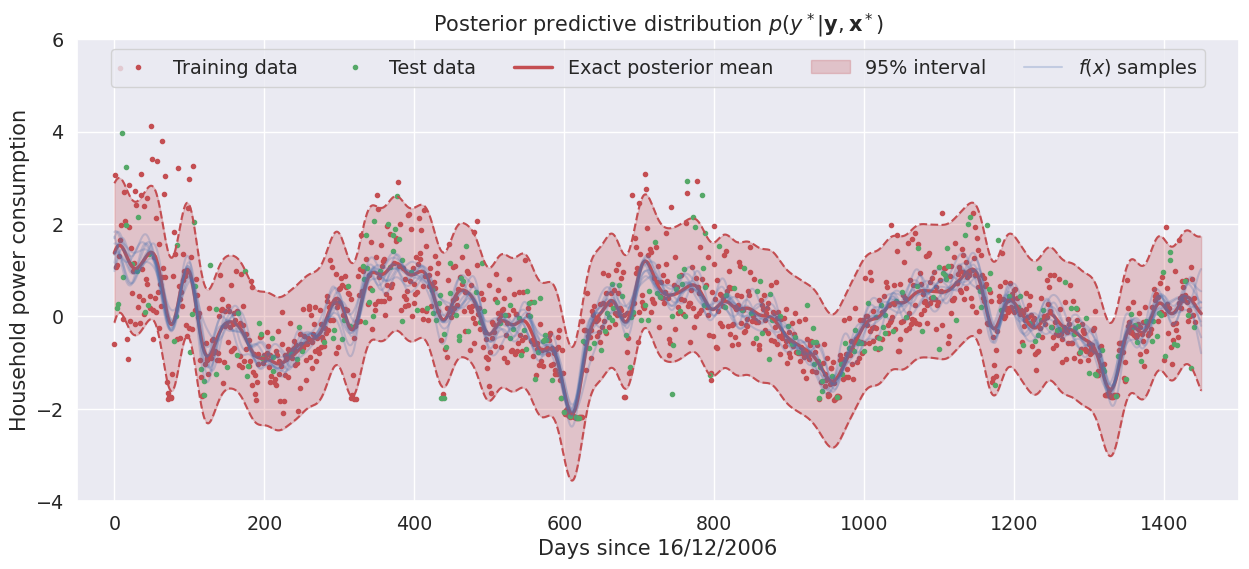

In [352]:
# interval for predictions
Xstar = np.arange(0, 1450)[:, None]

# visualize
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plot_data(ax)
plot_with_uncertainty(ax, Xstar, gp_exact, label='Exact posterior mean', title='Posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$', num_samples=10, color='r')
ax.legend(loc='upper center', ncol=5);


# evaluate for both training and test set
y_train_mu, y_train_var = gp_exact.predict_y(X_train)
y_test_mu, y_test_var = gp_exact.predict_y(X_test)

print(30*'*')
print('LPDs for exact GP inference')
print(30*'*')
print(f'Training LPD: {compute_LPD(y_train, y_train_mu, np.diag(y_train_var)):3.2f}')
print(f'    Test LPD: {compute_LPD(y_test, y_test_mu, np.diag(y_test_var)):3.2f}')


**End of solution**

**Task 6.2**: Fit the variational approximation for $M \in \left\lbrace 10, 20, \dots,  100\right\rbrace$ and estimate the training and test LPD for each $M$. Plot the predictive performance for the training and test set and compare to results for exact inference. How many inducing points do you need to before the difference in predictive performance between exact and approximate inference becomes negligible?

*Hints: This experiment took about 3 minutes to run on my laptop, but if it takes to much time, feel free to decrease the size of the training set a bit.*

**Solution**

In [353]:
# compute traing and test LPD using exact inference
y_train_mu, y_train_var = gp_exact.predict_y(X_train)
y_test_mu, y_test_var = gp_exact.predict_y(X_test)

# compute exact log marginal likelihood
log_marginal_lik = gp_exact.log_marginal_likelihood(gp_exact.kappa, gp_exact.lengthscale, gp_exact.sigma)

# preallocate
train_lpds = []
test_lpds = []
lowerbounds = []

# loop over different values for M
Ms = np.arange(10, 100+1, 10)
for M in Ms:

    print(f'Running M={M}')

    # choose inducing points and fit GP
    Z = np.linspace(0, 1450, M)[:, None]
    kernel = StationaryIsotropicKernel(squared_exponential, 1, 100)
    vgp = VariationalGaussianProcessRegression(X_train, y_train, Z, kernel, kappa=1, lengthscale=50, sigma=0.1)
    vgp.optimize_hyperparameters(np.array([1, 50, 1]))

    # make predictions
    y_train_mu_vgp, y_train_var_vgp = vgp.predict_y(X_train)
    y_test_mu_vgp, y_test_var_vgp = vgp.predict_y(X_test)

    # store results
    train_lpds.append(compute_LPD(y_train, y_train_mu_vgp, np.diag(y_train_var_vgp)))
    test_lpds.append(compute_LPD(y_test, y_test_mu_vgp, np.diag(y_test_var_vgp)))
    lowerbounds.append(vgp.lowerbound())

Running M=10
Running M=20
Running M=30
Running M=40
Running M=50
Running M=60
Running M=70
Running M=80
Running M=90
Running M=100


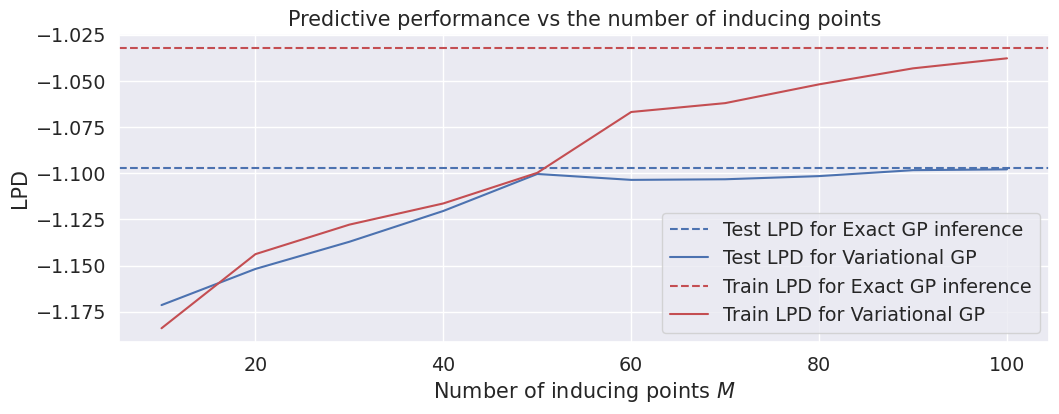

In [354]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.axhline(compute_LPD(y_test, y_test_mu, np.diag(y_test_var) ), color='b', linestyle='--', label='Test LPD for Exact GP inference')
ax.plot(Ms, test_lpds, color='b', label='Test LPD for Variational GP')
ax.axhline(compute_LPD(y_train, y_train_mu, np.diag(y_train_var) ), color='r', linestyle='--', label='Train LPD for Exact GP inference')
ax.plot(Ms, train_lpds, color='r', label='Train LPD for Variational GP')
ax.legend()
ax.set(xlabel='Number of inducing points $M$', ylabel='LPD', title='Predictive performance vs the number of inducing points');

**Task 6.3**: Compute the approximate posterior predictive distribution for $M = \left\lbrace 50, 100\right\rbrace$ and compare with exact posterior predictive distribution. How do the approximations differ from the exact result?

**Solution**

In [355]:
M = 50 
Z = np.linspace(0, 1450, M)[:, None]
kernel = StationaryIsotropicKernel(squared_exponential, 1, 100)
vgp50 = VariationalGaussianProcessRegression(X_train, y_train, Z, kernel, kappa=1, lengthscale=50, sigma=0.1)
vgp50.optimize_hyperparameters(np.array([1, 50, 1]))

array([ 0.63491216, 29.93037543,  0.73973814])

In [356]:
M = 100
Z = np.linspace(0, 1450, M)[:, None]
kernel = StationaryIsotropicKernel(squared_exponential, 1, 100)
vgp100 = VariationalGaussianProcessRegression(X_train, y_train, Z, kernel, kappa=1, lengthscale=50, sigma=0.1)
vgp100.optimize_hyperparameters(np.array([1, 50, 1]))

array([ 0.67164403, 16.03327302,  0.70298864])

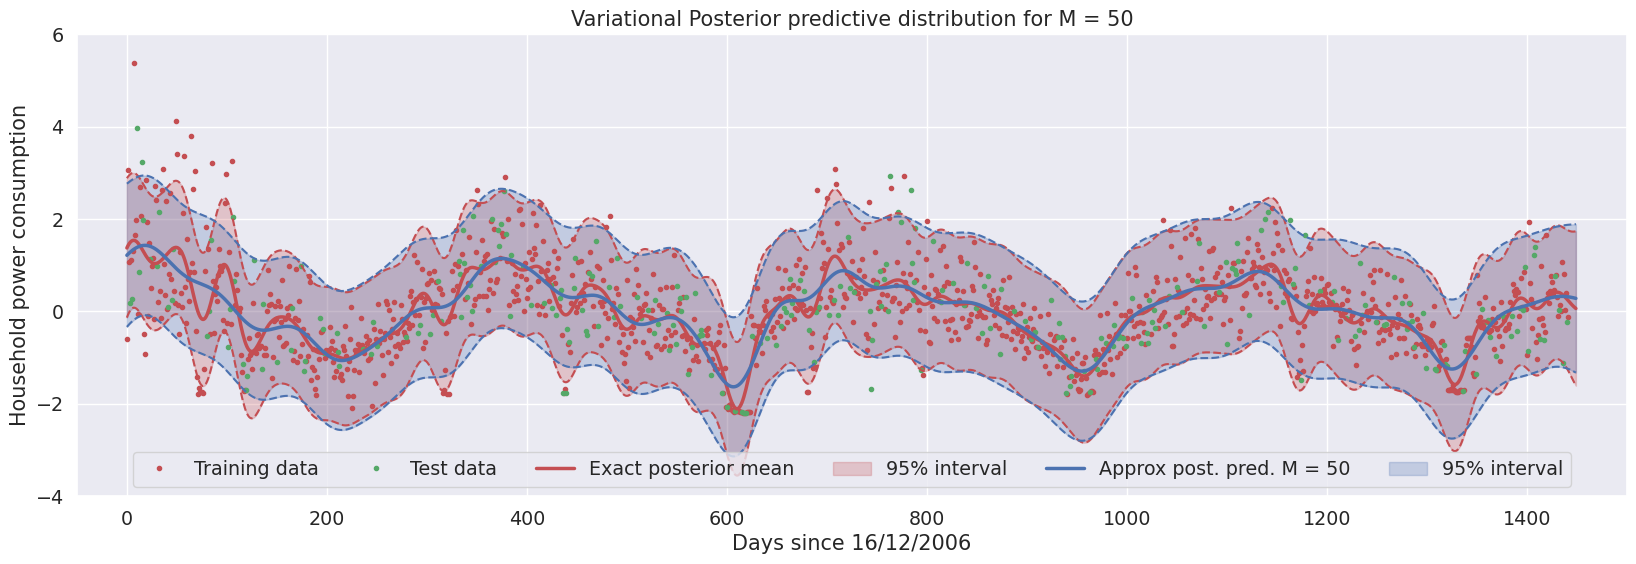

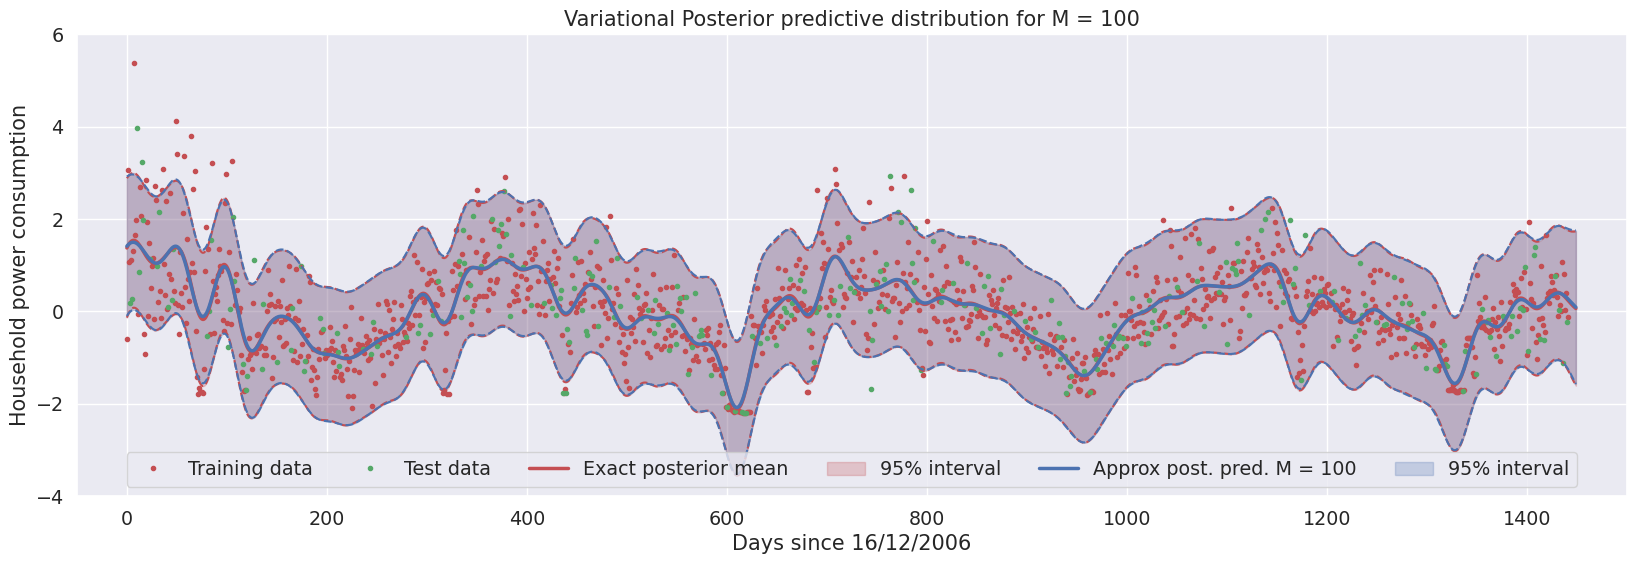

In [357]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
plot_data(ax)
plot_with_uncertainty(ax, Xstar, gp_exact, label='Exact posterior mean', title='Posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$', num_samples=0, color='r')
plot_with_uncertainty(ax, Xstar, vgp50, title='Variational Posterior predictive distribution for M = 50', num_samples=0, color='b', label='Approx post. pred. M = 50')
ax.legend(loc='lower center', ncol=6)

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
plot_data(ax)
plot_with_uncertainty(ax, Xstar, gp_exact, label='Exact posterior mean', title='Posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$', num_samples=0, color='r')
plot_with_uncertainty(ax, Xstar, vgp100, title='Variational Posterior predictive distribution for M = 100', num_samples=0, color='b', label='Approx post. pred. M = 100')
ax.legend(loc='lower center', ncol=6)

**End of solution**


---

